In [1]:
# Import liberaries and functions
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import re
import networkx as nx

## Board data

In [2]:
# Load BoardEX data
compo = pd.read_csv("Data/Board-Composition.csv", parse_dates=['AnnualReportDate']).drop(columns='Ticker').drop_duplicates()
# network = pd.read_csv("Data/Board-Network.csv")
direct = pd.read_csv("Data/Board-Directors.csv")
CoID_CIK = pd.read_csv("Data/CoID_CIK.csv")

committees = pd.read_csv(
    "Data/BoardEx_Committees.csv", parse_dates=['AnnualReportDate']
).drop_duplicates().reset_index(drop=True)


In [3]:
# If director is in a risk committee
committees['RiskCommittee'] = committees['CommitteeName'].str.contains(r"risk", case=False).astype(int)

# Only directors that are in risk committee (some directors are in multiple committees - to remove duplicates)
Risk_committee = committees.loc[
    committees['RiskCommittee']==1,
    ['AnnualReportDate', 'RiskCommittee', 'BoardID', 'DirectorID']
].drop_duplicates().reset_index(drop=True)

compo = pd.merge(
    left=compo,
    right=Risk_committee,
    on=['AnnualReportDate', 'BoardID', 'DirectorID'],
    how='left'
).fillna({'RiskCommittee': 0})

In [4]:
committees['AuditCommittee'] = committees['CommitteeName'].str.contains(r"audit", case=False).astype(int)

# Only directors that are in audit committee (some directors are in multiple committees - to remove duplicates)
Audit_committee = committees.loc[
    committees['AuditCommittee']==1,
    ['AnnualReportDate', 'AuditCommittee', 'BoardID', 'DirectorID']
].drop_duplicates().reset_index(drop=True)

compo = pd.merge(
    left=compo,
    right=Audit_committee,
    on=['AnnualReportDate', 'BoardID', 'DirectorID'],
    how='left'
).fillna({'AuditCommittee': 0})

In [5]:
# If it is an independent director
compo['Independent'] = compo["RoleName"].str.contains('Independent', case=False).astype(int)

# Get year of birth from date of birth
def DOB(bd):
    try:
        return int(re.findall(pattern='\d{4}', string=bd)[-1])
    except:
        return np.nan
    
direct["YOB"] = direct["DOB"].apply(DOB)

# Add 'YOB' of directors to the board composition DataFrame 
compo = pd.merge(
    left=compo,
    right = direct[['DirectorID', 'YOB']],
    on="DirectorID",
    how='left'
)

compo['Year'] = pd.to_datetime(compo['AnnualReportDate']).dt.year

compo['ED'] = (compo['NED']=='No').astype(int)

# Total number of boards that the board member is a member
compo['TotCurrBrd'] = compo[['TotCurrNoLstdBrd', 'TotCurrNoUnLstdBrd']].sum(axis=1)

compo['Age'] = compo['Year'] - compo['YOB']

compo.drop(columns=['RowType', 'BoardName'], inplace=True)

compo.fillna(
    {'NumberDirectors': compo.groupby(['BoardID', 'AnnualReportDate'])['DirectorID'].transform('nunique')},
    inplace=True
)

# # Number of boards membership per director per year
# compo["DirNetwork"] = compo.groupby(["DirectorID", "Year"])['BoardID'].transform("nunique")

In [6]:
# Calculate number of DirectorID shared with other BoardID per year
link_df = pd.merge(
    left=compo[['BoardID', 'DirectorID', 'Year', 'CIKCode', 'ED', 'RiskCommittee', 'AuditCommittee']],
    right=compo[['DirectorID', 'Year', 'BoardID', 'CIKCode', 'ED', 'RiskCommittee', 'AuditCommittee']],
    on=['DirectorID', 'Year'],
    how='outer',
    suffixes=["", "_lnkd"]
)

# # if the shared Dir is ED or RiskCommittee in either one of linked firms
# link_df['ED'] = link_df[['ED', 'ED_lnkd']].max(axis=1)
# link_df['RiskCommittee'] = link_df[['RiskCommittee', 'RiskCommittee_lnkd']].max(axis=1)

link_df.drop(columns=['ED_lnkd', 'RiskCommittee_lnkd', 'AuditCommittee_lnkd'], inplace=True)

link_df = link_df[link_df['BoardID']!=link_df['BoardID_lnkd']].drop_duplicates().reset_index(drop=True)

# Check if linked firm is financial
sich = pd.read_csv(
    filepath_or_buffer="Data/SICH.csv",
    usecols=['cik', 'fyear', 'sich', 'sic']
)

sich.fillna({'sich': sich['sic']}, inplace=True)
sich = sich.drop_duplicates().dropna().astype(int).reset_index(drop=True).drop(columns=['sic'])

link_df = pd.merge(
    left=link_df,
    right=sich,
    left_on=['Year', 'CIKCode_lnkd'],
    right_on=['fyear', 'cik'],
    how='left'
).drop(columns=['fyear', 'cik'])

sic = pd.read_csv("Data/SIC_df.csv")

link_df = pd.merge(
    left=link_df,
    right=sic[['cik', 'sic']],
    left_on=['CIKCode_lnkd'],
    right_on=['cik'],
    how='left'
).drop(columns=['cik'])

link_df.fillna({'sich': link_df['sic']}, inplace=True)

fin_sic = [6021, 6022, 6029, 6035, 6036, 6099, 6111, 6141, 6153, 6159, 6162, 6163, 6172, 6189, 6199,
6200, 6211, 6221, 6282, 6311, 6321, 6324, 6331, 6351, 6361, 6399, 6411]

link_df['Is_fin'] = link_df['sich'].isin(fin_sic)

# Link age
link_df = link_df.sort_values(['BoardID', 'BoardID_lnkd', 'Year']).reset_index(drop=True)
link_df['LinkTime'] = link_df.drop_duplicates(subset=['BoardID', 'BoardID_lnkd', 'Year']).groupby(['BoardID', 'BoardID_lnkd'])['Year'].cumcount()+1
link_df['LinkTime'] = link_df['LinkTime'].ffill()

In [7]:
# Total connections = max(ShrdDir, LnkdFirm)
NoShrDir = (
    link_df.groupby(['BoardID', 'Year']).agg(
        ShrdDir=('DirectorID', 'nunique'),
        LnkdFirm=('BoardID_lnkd', 'nunique'),
        FinLink=('Is_fin', 'sum'),
        LinkTime=('LinkTime', 'mean')
    )
)

# For directors that seat at multiple other firms
NoShrDir[["ShrdED", "ShrdRC", "ShrdAC"]] = link_df\
    .drop_duplicates(subset=['BoardID', 'DirectorID', 'Year', 'ED'])\
        .groupby(['BoardID', 'Year'])[['ED', 'RiskCommittee', 'AuditCommittee']].sum()

compo = pd.merge(
    left=compo, 
    right=NoShrDir,
    left_on=['BoardID', 'Year'],
    right_index=True,
    how='left'
)

compo.fillna(dict([(c, 0) for c in ["ShrdDir", "LnkdFirm", "ShrdED", "ShrdRC", "ShrdAC", "FinLink"]]), inplace=True)

In [8]:
# network df based on CIK
link_df.drop(columns=['BoardID', 'BoardID_lnkd'], inplace=True)
link_df = link_df.dropna().astype(int).reset_index(drop=True)

# Number of directors shared between each pair of firms
network_df = link_df.groupby(['Year', 'CIKCode', 'CIKCode_lnkd'])['DirectorID'].nunique().reset_index()

# Inverse number of shared directors between 2 individual firms as disctance between the 2
network_df['Distance'] = 1/network_df['DirectorID']

In [9]:
centrality_list = []
Years = network_df['Year'].unique()

for yr in tqdm(Years):
    df = network_df[network_df['Year']==yr].drop(columns='Year')

    G = nx.from_pandas_edgelist(
        df=df,
        source='CIKCode',
        target='CIKCode_lnkd',
        edge_attr='Distance'
    )

    degree = nx.degree_centrality(G) # fraction of direct connections
    # closeness = nx.closeness_centrality(G, distance='Disctance')
    # betweenness = nx.betweenness_centrality(G, weight='Distance')
    # eigenvector = nx.eigenvector_centrality(G, weight='Distance')

    df = pd.concat([
        pd.Series(degree, name='Degree'), 
        # pd.Series(closeness, name='Closeness'), 
        # pd.Series(betweenness, name='Betweenness'),
        # pd.Series(eigenvector, name='Eigenvector')
    ], axis=1).reset_index().rename(columns={'index': 'CIKCode'})

    df['Year'] = yr

    centrality_list.append(df)
    
centrality_df = pd.concat(centrality_list)

  0%|          | 0/19 [00:00<?, ?it/s]

In [10]:
# Drop NaN CIK codes
compo.dropna(subset=['CIKCode'], inplace=True)
compo['CIKCode'] = compo['CIKCode'].astype(int)

compo = pd.merge(
    left=compo, 
    right=centrality_df,
    on=['CIKCode', 'Year'],
    how='left'
)

compo.fillna({'Degree': 0, 'Closeness': 0, 'Betweenness': 0}, inplace=True)

In [11]:
# Board composition average per firm year
compo_sum = compo.groupby(['CIKCode', 'Year'])[[
    'GenderRatio', 'NationalityMix', 'NumberDirectors', 'TotCurrBrd', 'Age', 
    'ShrdDir', 'LnkdFirm', "ShrdED", "ShrdRC", "ShrdAC", 'FinLink', 'LinkTime',
    'Degree', # 'Closeness', 'Betweenness'
]].mean()

# compo_sum['AgeStd'] = compo.groupby(['CIKCode', 'Year'])['Age'].std()
compo_sum['Independent'] = compo.groupby(['CIKCode', 'Year'])['Independent'].sum()

compo_sum = compo_sum.reset_index().sort_values(by=['CIKCode', 'Year'])

## Risk Disclosures

H: Firms disclose more RFs if they have more linked firms/shared directors\
H: Firms add new directors from other companies if they have more new risk factors in year t-1

In [12]:
# Load RF data 
topics_df = pd.read_csv("Data/RDdf_T2V5.csv", parse_dates=['report_dt', 'filing_dt'])
print(topics_df.shape)
topics_df.columns

(3245397, 23)


Index(['Topic', 'Score', 'Topic_H', 'Score_H', 'CIK', 'report_dt', 'filing_dt',
       'rf_seq', 'ticker', 'filerCIK', 'rf_length', 'NERs', 'Pa', 'Pr', 'Fu',
       'Sentiment', 'FOG', 'clean_len', 'SIC', 'FF', 'ryear', 'fyear',
       'rf_seq_count'],
      dtype='object')

In [13]:
topics_df['Topic'].nunique()

6896

In [14]:
topics_df['NERs'] = topics_df['NERs'].str.replace(pat=" ", repl="").str.findall(pat=r"'(.*?)'")

NE_labels = ['PERSON', 'NORP' 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'LAW', 'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY']
topics_df['Specificity'] = topics_df['NERs'].apply(lambda NERs: len([ne for ne in NERs if ne in NE_labels]))

topics_df['SIC3'] = topics_df['SIC'].map(lambda x: f"{int(x):04d}"[:3])

In [15]:
# replace length of raw RF with cleaned RF
topics_df["rf_length"] = topics_df["clean_len"]
topics_df.drop(columns="clean_len", inplace=True)

In [16]:
# Aggregate the records at the CIK-year level
agg_tops = (
    topics_df.groupby(["CIK", "report_dt", "filing_dt", "FF"])[
        ['rf_length', 'SIC3', 'Specificity', 'Pa', 'Pr', 'Fu', 'Sentiment']
    ]
    .agg({
        'rf_length': 'sum',
        'SIC3' : 'unique',
        'Specificity': 'sum',
        'Pa': 'sum', 'Pr': 'sum', 'Fu': 'sum',
        'Sentiment': 'mean', 
    }).reset_index()
).drop_duplicates(subset=["CIK", "filing_dt", "report_dt"]).sort_values(["CIK", "filing_dt", "report_dt"])

agg_tops['length_1'] = agg_tops.drop_duplicates(subset=['CIK', 'filing_dt']).groupby(["CIK"])['rf_length'].shift(1)
agg_tops['length_1'] = agg_tops.groupby('CIK')['length_1'].ffill()
agg_tops['Delta_length'] = agg_tops['rf_length'] - agg_tops['length_1']
agg_tops.drop(columns='length_1', inplace=True)

agg_tops["SIC3"] = agg_tops["SIC3"].map(lambda x: x[0])

In [17]:
# Risk factor clusters disclosed and not disclosed per report 
disc_df = pd.pivot_table(
    topics_df, index = ["CIK", "filing_dt", "report_dt", "FF"], 
    columns='Topic', values='Score'
).notna().astype(int).sort_values(["CIK", "filing_dt", "report_dt"]).reset_index()

disc_df['ryear'] = disc_df["report_dt"].dt.year

# Drop firm-year observations with more than 1 report in one fiscal year
disc_df.drop_duplicates(subset=disc_df.columns.difference(["filing_dt", "report_dt"]), keep="first", inplace=True)

In [18]:
N = topics_df['Topic'].nunique()
# Difference between disclosed risk topics in 2 consecutive years
disc_diff = disc_df.filter(range(N)) - disc_df.groupby("CIK")[disc_df.filter(range(N)).columns].shift(1)

# Repeated risk factors
disc_repeat = (
    disc_df.filter(range(N))
    + disc_df.groupby("CIK")[disc_df.filter(range(N)).columns].shift(1) 
    == 2
).astype(int)

# Number of added, repeated and removed individual topics
disc_df["reported"] = disc_df.filter(range(N)).sum(axis=1)
disc_df["repeated"] = disc_repeat[disc_repeat>0].sum(axis=1)
disc_df["added"] = disc_diff[disc_diff>0].sum(axis=1)
disc_df["removed"] = disc_diff[disc_diff<0].sum(axis=1)


In [19]:
stat_data = pd.merge(
    left=agg_tops,
    right=disc_df[['CIK', 'filing_dt', 'report_dt', 
                   'reported', 'repeated', 'added', 'removed']],
    on=['CIK', 'filing_dt', 'report_dt'],
    how='left'
)
# Number of days from fiscal year end and actual filing date
stat_data['rfGap'] = (stat_data['filing_dt'] - stat_data['report_dt']).dt.days

stat_data['fyear'] = stat_data['filing_dt'].dt.year
stat_data['ryear'] = stat_data['report_dt'].dt.year

# Add Item 1A FOG
Item1A_Fog = pd.read_csv("Data/Item1A_FOG.csv", parse_dates=['report_dt', 'filing_dt'])
stat_data = pd.merge(
    left=stat_data,
    right=Item1A_Fog,
    on=['CIK', 'filing_dt', 'report_dt'],
    how='left'
)

# Number of added and removed one year ahead
stat_data[["added+1", "removed+1", "Specificity+1", "Sentiment+1", "Item1AFOG+1"]] = \
    stat_data.groupby('CIK')[['added', 'removed', "Specificity", "Sentiment", "Item1AFOG"]].shift(-1)

# Number of added and removed one year before
stat_data[["added_1", "removed_1", "Specificity_1", "Sentiment_1", "Item1AFOG_1"]] = \
    stat_data.groupby('CIK')[['added', 'removed', "Specificity", "Sentiment", "Item1AFOG"]].shift(1)

In [20]:
# duplicated ryears with report at the begining of the year
disc_df['ryear_dupd'] = disc_df.duplicated(subset=['CIK', 'ryear'], keep='last')

disc_df["ryear-1"] = disc_df.groupby('CIK')['ryear'].shift(1)

# change ryear if duplicated and there is a gap between two report years 
disc_df['ryear'] = disc_df[['ryear_dupd', 'ryear', 'ryear-1']].apply(
    lambda x: x['ryear']-1 if x['ryear_dupd'] and x['ryear']-1>x['ryear-1'] else x['ryear'],
    axis=1
)

disc_df = disc_df\
    .drop_duplicates(subset=['CIK', 'ryear'], keep='first')\
        .reset_index(drop=True).drop(columns=['ryear_dupd', 'ryear-1'])

## Control variables

Volatility

In [21]:
prices_df = pd.read_csv("Data\Prices2.csv", parse_dates=['datadate'])

prices_df.rename(columns={'cik': 'CIK', 'datadate': 'filing_dt'}, inplace=True)
prices_df = prices_df.sort_values(["CIK", "filing_dt"]).set_index('filing_dt')
prices_df.columns

Index(['CIK', 'VOLUME', 'TTLCMNSHARESOUT', 'CLOSEPRICE'], dtype='object')

In [22]:
# Daily shares turnover
prices_df["SHRTURN"] = prices_df["VOLUME"] / prices_df["TTLCMNSHARESOUT"]

prices_df["Return"] = prices_df.groupby("CIK")["CLOSEPRICE"].pct_change(1, fill_method=None)

In [23]:
# Combine the list of CIKs and filing date in main dataframe and prices df
CIKdates = pd.concat(
    [prices_df.reset_index()[["CIK", "filing_dt"]], disc_df[["CIK", "filing_dt"]]], 
    axis=0
).drop_duplicates().sort_values(["CIK", "filing_dt"])

prices_df.reset_index(inplace=True)
prices_df = pd.merge(left=CIKdates, right=prices_df, on=["CIK", "filing_dt"], how='left')
prices_df.set_index('filing_dt', inplace=True)

In [24]:
prices_df.shape

(21224795, 6)

In [25]:
# Combine the list of CIKs and filing date in main dataframe and prices df
CIKdates = pd.concat(
    [prices_df.reset_index()[["CIK", "filing_dt"]], disc_df[["CIK", "filing_dt"]]], 
    axis=0
).drop_duplicates().sort_values(["CIK", "filing_dt"])

prices_df.reset_index(inplace=True)
prices_df = pd.merge(left=CIKdates, right=prices_df, on=["CIK", "filing_dt"], how='left')
prices_df.set_index('filing_dt', inplace=True)

In [26]:
# Time window
N = 30

# Average of N-day std of daily returns
std_returns = (
    prices_df.groupby("CIK")["Return"]
    .rolling(N, min_periods=N//2).std().to_frame()
)
# Window [2, 32]
std_returns[f"Volatility+{N}"] = std_returns.groupby("CIK")["Return"].shift(-N-2)
# Window [-32, -2]
std_returns[f"Volatility_{N}"] = std_returns.groupby("CIK")["Return"].shift(2)

# Window [-5, 60]
std_returns[f"Volatility+60"] = prices_df.groupby("CIK")["Return"].rolling(65, min_periods=30).std().groupby("CIK").shift(-60)

# Average of 120-day std of daily returns
std_returns[f"Volatility_120"] = prices_df.groupby("CIK")["Return"].rolling(120, min_periods=60).std()

std_returns.drop(columns="Return", inplace=True)

In [27]:
# Average of N-day trade volumes during event
N=10
MA_vol = prices_df.groupby("CIK")["SHRTURN"].rolling(N, min_periods=6).mean().to_frame()
MA_vol[f"SHRTURN"] = MA_vol.groupby("CIK")["SHRTURN"].shift(N//2)

In [28]:
Beta = pd.read_csv("Data\Beta_AR.csv", parse_dates=['datadate'])
Beta.drop_duplicates(inplace=True)
Beta.columns

Index(['datadate', 'CIK', 'Beta_63', 'Beta_126', 'Beta_252', 'CAR_2', 'CAR_5',
       'CAR_10'],
      dtype='object')

In [29]:
Beta.rename(columns={"Instrument": "CIK", "datadate": "filing_dt"}, inplace=True)
Beta = pd.merge(left=CIKdates, right=Beta, on=["CIK", "filing_dt"], how='left')
Beta.set_index(['CIK', 'filing_dt'], inplace=True)

In [30]:
# Daily Beta
Beta["BETA+126"] = Beta.groupby('CIK')["Beta_126"].shift(-120)
Beta["BETA+63"] = Beta.groupby('CIK')["Beta_63"].shift(-60)

Analysts

In [31]:
Analysts = pd.read_csv("Data/Analysts.csv", parse_dates=['Date'])

Analyst_df = pd.merge(
    left=prices_df.reset_index()[["filing_dt", "CIK"]], 
    right=Analysts, 
    left_on=["filing_dt", "CIK"],
    right_on=["Date", "Instrument"],
    how="outer"
).drop(columns=["Date", "Instrument"])

Analyst_df.sort_values(['CIK', 'filing_dt', 'NUMBEROFANALYSTS'], inplace=True)


In [32]:
Analyst_df["NUMBEROFANALYSTS"] = Analyst_df.groupby("CIK")["NUMBEROFANALYSTS"].ffill()
Analyst_df.drop_duplicates(subset=["filing_dt", "CIK"], keep='last', inplace=True)
Analyst_df.dropna(how='all', inplace=True)

Fama-French industry portfolio volatility

In [33]:
# Returns in % 
FF_rtrn = pd.read_csv("FF_Industry_Portfolios_daily/IndustryDaily.csv", parse_dates=["Date"], index_col=['Date'])

# STDs in % - Do not *100 in stata
FF_vol = FF_rtrn.rolling(126).std().dropna().unstack().reset_index() 
FF_vol.rename(columns={"level_0": "FF", "level_1": "Date", 0: "IndVol_"}, inplace=True)
FF_vol["FF"] = FF_vol["FF"].astype(int)

# Foreward looking IndVol
FF_vol["IndVol+"] = FF_vol.groupby("FF")['IndVol_'].shift(-126)

Internal control

In [34]:
ICW = pd.read_csv("Data/ICW.csv", parse_dates=['FYE_IC_OP', 'FILE_DATE'])

ICW.sort_values(['COMPANY_FKEY', 'FILE_DATE'], inplace=True)

ICW["OPyr"] = ICW['FYE_IC_OP'].dt.year
ICW["fyear"] = ICW['FILE_DATE'].dt.year

# ICW.dropna(subset=['LAST_AUD_NAME'], inplace=True)

# # Replace unknown auditors with last known auditors
# ICW.loc[ICW['OP_AUD_NAME']=='unknown', 'OP_AUD_NAME'] = ICW.loc[ICW['OP_AUD_NAME']=='unknown', 'LAST_AUD_NAME']
# ICW.loc[ICW['AUDITOR_FKEY']==216, 'AUDITOR_FKEY'] = ICW.loc[ICW['AUDITOR_FKEY']==216, 'LAST_AUD_FKEY']

In [35]:
ICW['Big4'] = ICW['OP_AUD_NAME'].str.contains(r'Deloitte|KPMG|Ernst|Pricewaterhouse', case=False).astype(int)

ICW_gr = ICW.groupby(['COMPANY_FKEY', 'FILE_DATE'])[['COUNT_WEAK', 'Big4', 'AUDITOR_FKEY']].max().reset_index()
ICW_gr2 = ICW.groupby(['COMPANY_FKEY', 'fyear'])[['COUNT_WEAK', 'Big4', 'AUDITOR_FKEY']].max().reset_index()

In [36]:
stat_data = pd.merge(
    left=stat_data,
    right=ICW_gr,
    left_on=['CIK', 'filing_dt'],
    right_on=['COMPANY_FKEY', 'FILE_DATE'],
    how="left"
).drop(columns=['COMPANY_FKEY', 'FILE_DATE'])

In [37]:
stat_data[['COUNT_WEAK_2', 'Big4_2', 'AUDITOR_FKEY_2']] = pd.merge(
    left=stat_data,
    right=ICW_gr2,
    left_on=['CIK', 'fyear'],
    right_on=['COMPANY_FKEY', 'fyear'],
    how="left"
)[['COUNT_WEAK_y', 'Big4_y', 'AUDITOR_FKEY_y']]

In [38]:
stat_data.fillna({'COUNT_WEAK': stat_data['COUNT_WEAK_2']}, inplace=True)
stat_data.fillna({'Big4': stat_data['Big4_2']}, inplace=True)
stat_data.fillna({'AUDITOR_FKEY': stat_data['AUDITOR_FKEY_2']}, inplace=True)

stat_data.drop(columns=['COUNT_WEAK_2', 'Big4_2', 'AUDITOR_FKEY_2'], inplace=True)

Shares held

In [39]:
Owner = pd.read_csv("Data\EIKON_Ownership.csv", parse_dates=['Date'])

Invetors = [
    'Bank and Trust', 'Corporation', 'Hedge Fund', 'Insurance Company',
    'Investment Advisor/Hedge Fund', 'Pension Fund', 'Research Firm',
    'Sovereign Wealth Fund', 'Venture Capital', 'Foundation',
    'Endowment Fund', 'Holding Company', 'Independent Research Firm',
    'Private Equity', 'Mutual Fund', 'Institution', 'Hedge Fund Portfolio',
    'Government Agency', 'Exchange-Traded Fund', 'Brokerage Firms']

Owner = Owner[Owner['Category Value'].isin(Invetors)].groupby(['Instrument', 'Date'])['Percent Of Traded Share'].sum().reset_index()

Owner.rename(columns={'Percent Of Traded Share': 'InstOwnership'}, inplace=True)

Financial data

In [40]:
financials = pd.read_csv("Data\Financials3.csv", parse_dates=['datadate']).drop_duplicates()

In [41]:
# Leverage
financials["DtA"] = financials["dt"] / financials["at"].replace(0, np.nan)

# Profitability
financials["ROE"] = financials["ni"] / financials["seq"].replace(0, np.nan)
financials["NPM"] = financials["ni"] / financials["revt"].replace(0, np.nan) # net profit margin
financials["ROA"] = financials["ni"] / financials["at"].replace(0, np.nan) 

# Firm size
financials["logMC"] = np.log(financials["mkvalt"].replace(0, np.nan))
financials["logTA"] = np.log(financials["at"].replace(0, np.nan))

# Intangible assets
financials["INTtA"] = financials["intan"] / financials["at"].replace(0, np.nan) 

# Liquidity
financials["Current"] = financials["act"] / financials["lct"].replace(0, np.nan)

# Other
financials["TobinQ"] = financials["mkvalt"] / financials["at"].replace(0, np.nan)
financials["BtM"] = financials["seq"] / financials["mkvalt"].replace(0, np.nan)

# R&D intensity
financials["RDxopr"] = financials["xrd"].fillna(0) / financials["xopr"].replace(0, np.nan)
financials["ProprietaryCost"] = financials["xrd"].fillna(0) / financials.groupby('cik')["at"].shift(1).replace(0, np.nan)

In [42]:
financials['ryear'] = financials['datadate'].dt.year
financials['rmonth'] = financials['datadate'].dt.month

In [43]:
financials["NAs"] = financials.isna().sum(axis=1)
financials.sort_values(["cik", "ryear", "rmonth", 'NAs'], inplace=True)
financials.drop_duplicates(subset=["cik", "ryear", "rmonth"], keep='first', inplace=True)

## Merge data

In [44]:
Study2_data = pd.merge(
    left=stat_data,
    right=compo_sum,
    left_on=['CIK', 'ryear'],
    right_on=['CIKCode', 'Year'],
    how='left'
).drop(columns=['CIKCode', 'Year'])

cols = ['GenderRatio', 'NationalityMix', 'NumberDirectors', 'TotCurrBrd', 'Age',
       'ShrdDir', 'LnkdFirm', 'ShrdED', 'ShrdRC', 'ShrdAC', 'FinLink', 'Degree', 'LinkTime', 'Independent']

# Fill missing values with previous year (if any)
Study2_data[cols] = Study2_data.groupby('CIK')[cols].ffill(limit=1)

# Fill missing values with next year (if any)
Study2_data[cols] = Study2_data.groupby('CIK')[cols].bfill(limit=1)

In [45]:
Study2_data = pd.merge(
    left=Study2_data,
    right=std_returns,
    left_on=["CIK", "filing_dt"],
    right_index=True,
    how="left"
)

Study2_data = pd.merge(
    left=Study2_data,
    right=MA_vol,
    left_on=["CIK", "filing_dt"],
    right_index=True,
    how="left"
)

In [46]:
Study2_data = pd.merge(
    left=Study2_data,
    right=Beta.reset_index()[[
        'CIK', 'filing_dt', 'Beta_126'
    ]],
    on=["CIK", "filing_dt"],
    how="left"
)

Study2_data = pd.merge(
    left=Study2_data,
    right=Analyst_df[["CIK", "filing_dt", 'NUMBEROFANALYSTS']],
    on=["CIK", "filing_dt"],
    how="left"
)
Study2_data.fillna({"NUMBEROFANALYSTS": 0}, inplace=True)

In [47]:
Study2_data["ryear"] = Study2_data['report_dt'].dt.year
Study2_data["rmonth"] = Study2_data['report_dt'].dt.month

fin_cols = ['DtA', 'ROE', 'NPM', 'mkvalt', 'logMC', 'at', 'logTA', 'INTtA', 
            'Current', 'TobinQ', 'BtM', 'RDxopr', 'ProprietaryCost', 'ROA']

Study2_data = pd.merge(
    left=Study2_data,
    right=financials[['cik', 'ryear', 'rmonth', *fin_cols]],
    left_on=["CIK", "ryear", "rmonth"],
    right_on=["cik", "ryear", "rmonth"],
    how="left"
)

financials.sort_values(["cik", "ryear", 'NAs'], inplace=True)
financials.drop_duplicates(subset=["cik", "ryear"], keep='first', inplace=True)

df = pd.merge(
    left=Study2_data,
    right=financials,
    left_on=["CIK", "ryear"],
    right_on=["cik", "ryear"],
    how="left",
    suffixes=['', '_2']
)

Study2_data.fillna(dict([(col, df[f"{col}_2"]) for col in fin_cols]), inplace=True)

In [48]:
Study2_data = pd.merge(
    left=Study2_data,
    right=FF_vol,
    left_on=["FF", "filing_dt"],
    right_on=["FF", "Date"],
    how="left"
).drop(columns="Date")

Study2_data["fmonth"] = Study2_data['filing_dt'].dt.month

Owner['fyear'] = Owner['Date'].dt.year
Owner['fmonth'] = Owner['Date'].dt.month

Study2_data = pd.merge(
    left=Study2_data,
    right=Owner,
    left_on=["CIK", "fyear", "fmonth"],
    right_on=["Instrument", "fyear", "fmonth"],
    how="left"
).drop(columns=['Instrument', 'Date', 'fmonth'])

Study2_data['InstOwnership'] = Study2_data.groupby('CIK')['InstOwnership'].bfill(limit=1)

In [49]:
Study2_data.columns

Index(['CIK', 'report_dt', 'filing_dt', 'FF', 'rf_length', 'SIC3',
       'Specificity', 'Pa', 'Pr', 'Fu', 'Sentiment', 'Delta_length',
       'reported', 'repeated', 'added', 'removed', 'rfGap', 'fyear', 'ryear',
       'Item1AFOG', 'added+1', 'removed+1', 'Specificity+1', 'Sentiment+1',
       'Item1AFOG+1', 'added_1', 'removed_1', 'Specificity_1', 'Sentiment_1',
       'Item1AFOG_1', 'COUNT_WEAK', 'Big4', 'AUDITOR_FKEY', 'GenderRatio',
       'NationalityMix', 'NumberDirectors', 'TotCurrBrd', 'Age', 'ShrdDir',
       'LnkdFirm', 'ShrdED', 'ShrdRC', 'ShrdAC', 'FinLink', 'LinkTime',
       'Degree', 'Independent', 'Volatility+30', 'Volatility_30',
       'Volatility+60', 'Volatility_120', 'SHRTURN', 'Beta_126',
       'NUMBEROFANALYSTS', 'rmonth', 'cik', 'DtA', 'ROE', 'NPM', 'mkvalt',
       'logMC', 'at', 'logTA', 'INTtA', 'Current', 'TobinQ', 'BtM', 'RDxopr',
       'ProprietaryCost', 'ROA', 'IndVol_', 'IndVol+', 'InstOwnership'],
      dtype='object')

In [50]:
Study2_data.sort_values(['CIK', 'report_dt'], inplace=True)
cols = [
    'NumberDirectors', 'ShrdDir', 'LnkdFirm', 'ShrdED', 'ShrdRC', 'ShrdAC', 'Independent', 'GenderRatio',
    'Volatility_120', 'Beta_126', 'IndVol_', 'logTA', 'ROE', 'DtA', 'Current', 'RDxopr', 'BtM',
    'rfGap', 'Big4', 'COUNT_WEAK', 'NUMBEROFANALYSTS', 'reported'
]
Study2_data[[f"{c}_1" for c in cols]] = Study2_data.groupby("CIK")[cols].shift(1)

In [51]:
Study2_data.dropna(subset='Delta_length', inplace=True)

Study2_data = Study2_data[Study2_data.groupby('CIK')['ryear'].transform('nunique')>1].reset_index(drop=True)

In [52]:
sharedRT = pd.read_csv('Data/Study2_data3_V2.csv')
sharedRT = sharedRT[sharedRT['Linked']==1].groupby(['CIK', 'ryear'])['SharedRF'].mean().reset_index()

In [53]:
Study2_data = pd.merge(
    left=Study2_data,
    right=sharedRT,
    on=["CIK", "ryear"],
    how="left"
)

In [54]:
Study2_data.shape

(72279, 96)

In [55]:
Study2_data.to_csv('Data/Study2_data1_V3.csv', index=False)

Study2_data_V1.csv --> Interlocks identified using Board Composition data

NetworkSize --> Network size of selected indivdual (number of overlaps through employment, other activities, and education)\
BoardID = CompanyID

In [1]:
import pandas as pd
import numpy as np

In [2]:
Study2_data1 = pd.read_csv('Data/Study2_data1_V2.csv')
Study2_data2 = pd.read_csv('Data/Study2_data2_V2.csv')

In [8]:
Study2_data1 = pd.merge(
    left=Study2_data1,
    right=Study2_data2.groupby(['CIK', 'ryear'])['IndDisc'].mean().reset_index(),
    on=['CIK', 'ryear'],
    how='left'
)

In [10]:
Study2_data1.to_csv('Data/Study2_data1_V2.csv', index=False)

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rc('figure', autolayout=True)
# plt.figure(figsize=(10,10))
# nx.draw(G, node_size=10)

In [58]:
Study2_data['ShrdDir'] = np.log(Study2_data['ShrdDir'])

c:\Users\u0147656\Anaconda3\envs\PhD_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [59]:
plotdata = Study2_data.groupby('CIK')[['ShrdDir', 'reported']].mean().dropna()

In [60]:
plotdata = plotdata[(plotdata['reported']>0)&(plotdata['ShrdDir']>0)]

Text(0, 0.5, 'Avg. Risk factors')

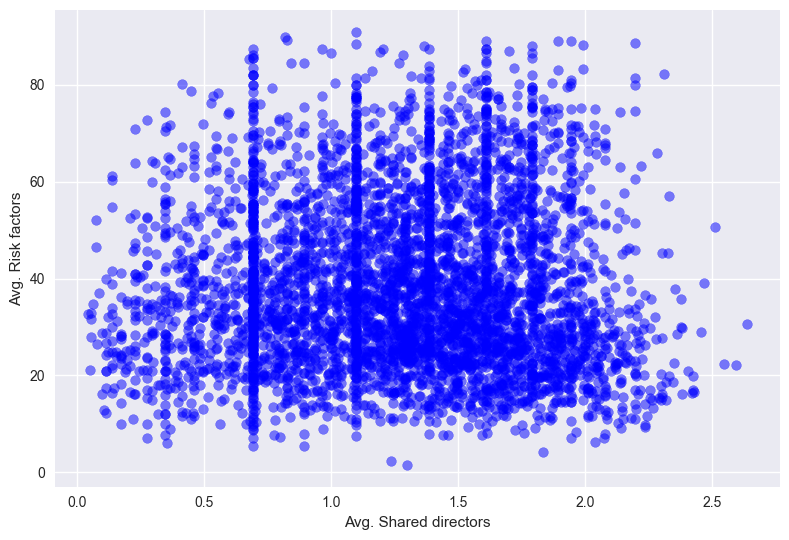

In [61]:
plt.scatter(plotdata['ShrdDir'], plotdata['reported'], alpha=0.5, c='blue')
plt.xlabel("Avg. Shared directors")
plt.ylabel("Avg. Risk factors")

In [62]:
# # Matching Board IDs (for the focal firms) and Company IDs (for the linked firms) to corresponding CIKs
# network = pd.merge(
#     left=network,
#     right=CoID_CIK,
#     on='BoardID',
#     how='left'
# ).rename(columns={'CIKCode': 'CIK'})

# network = pd.merge(
#     left=network,
#     right=CoID_CIK,
#     left_on='CompanyID',
#     right_on='BoardID',
#     how='left'
# ).drop(columns='BoardID_y').rename(columns={'CIKCode': 'LnkdCIK', 'BoardID_x': 'BoardID'})

# # # Only keep associations with listed firms
# # network = network[network["AssociationType"]=='Listed Org'].reset_index(drop=True)

# network["OverlapYearEnd"] = network["OverlapYearEnd"].replace('Curr', '2024').astype(int)

# # Drop observation with missing CIKs
# network.dropna(subset=['CIK', 'LnkdCIK'], inplace=True)
# network[['CIK', 'LnkdCIK']] = network[['CIK', 'LnkdCIK']].astype(int)

# # If the director is a brd member or not
# network["NonBrd"] = network["Role"].str.contains(r"Non-Brd")
# network["LnkdNonBrd"] = network["AssociatedRole"].str.contains(r"Non-Brd")

# # Only keep observations that are board members either in the first or second firm
# network.drop(
#     network[(network['NonBrd']==True)&(network['LnkdNonBrd']==True)].index, 
#     inplace=True
# )

In [63]:
# # What are the associations for every CIK per year
# network_list = []
# years = range(2005, 2024)
# CIKs = network["CIK"].unique()

# for cik in tqdm(CIKs):
#     firm = network[network['CIK']==cik]

#     for yr in years:
#         firm['Year'] = yr

#         # Keep only those associations that are valid in the specific year yr
#         firm_year = firm[(firm["OverlapYearStart"]<=yr)&(firm["OverlapYearEnd"]>=yr)]

#         network_list.append(firm_year)

# # Merge all firm_year DataFrames
# network_df = pd.concat(network_list)
# network_df.reset_index(drop=True, inplace=True)

# # Save file
# network_df.to_csv("Data/Network_df.csv", index=False)

In [64]:
# network_df = pd.read_csv("Data/Network_df.csv")

# # Number of directors linked with other firms
# network_df.groupby(['CIK', 'Year'])['DirectorID'].nunique()

# # Number of linked firms
# network_df.groupby(['CIK', 'Year'])['CompanyID'].nunique()

# # Average number of directors shared with every other linked firm
# network_df.groupby(['CIK', 'Year'])['CompanyID'].count()/network_df.groupby(['CIK', 'Year'])['CompanyID'].nunique()

PERSON:      People, including fictional.
ORG:         Companies, agencies, institutions, etc.
GPE:         Countries, cities, states.
LOC:         Non-GPE locations, mountain ranges, bodies of water.
PRODUCT:     Objects, vehicles, foods, etc. (Not services.)
EVENT:       Named hurricanes, battles, wars, sports events, etc.
LAW:         Named documents made into laws.
DATE:        Absolute or relative dates or periods.
TIME:        Times smaller than a day.
PERCENT:     Percentage, including ”%“.
MONEY:       Monetary values, including unit.
QUANTITY:    Measurements, as of weight or distance.
NORP:        Nationalities or religious or political groups.